In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from xgboost import XGBRegressor, plot_tree
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

rcParams['figure.figsize'] = 12, 6
sns.set_style('whitegrid')
%matplotlib inline

# 1. Preprocessing & Feature Engineering

## 1.1 `Wrangle Function`

In [2]:
#split date
def get_date(data):
    data['Year'] = pd.to_datetime(data['Date']).dt.year
    data['Month'] = pd.to_datetime(data['Date']).dt.month
    data['Quarter'] = pd.to_datetime(data['Date']).dt.quarter
    data['Day'] = pd.to_datetime(data['Date']).dt.day
    return data

In [3]:
# competition oepn duration(in months)
def comp_months(data):
    data['CompetitionOpen'] = 12* (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0) 
    return data

In [4]:
#outliers treatments
out_cols = ['Sales', 'CompetitionOpen']
def outliers(data):
    for c in out_cols:
        q5, q95 = data[c].quantile([0.05, 0.95])
        mask = data[c].between(q5, q95)
        data = data[mask]
    return data

In [5]:
def wrangle(filepath, store_data):

    #load train/test data
    train_df = pd.read_csv(filepath, low_memory = False)
    
    #load store data
    store_df = pd.read_csv(store_data)
    
    #merge dataset
    data = train_df.merge(store_df, on = 'Store', how = 'left').copy()
    
    #split date
    data = get_date(data)
    
    #create CompetitionOpen columns (age of CompetitionOpen in months)
    data = comp_months(data)
    
    #replace int by month name in 'Month col'
    month_dict = {
    1:'Jan', 2:'Feb', 
    3:'Mar', 4:'Apr',
    5:'May', 6:'Jun',              
    7:'Jul', 8:'Aug',
    9:'Sept', 10:'Oct', 
    11:'Nov', 12:'Dec'
    }
    data['Month'] = data['Month'].replace(month_dict).copy()
    
    # drop columns 
    col = ['Date', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']
    cols = col + ([c for c in data.columns if data[c].isna().sum()/len(data) >= 0.40])
    
    # #remove colinarity column
    if 'Customers' in data.columns:
        cols.append('Customers')
#         data = data.drop('Customers', axis = 1).copy() 
#         return data

    data = data.drop(cols, axis = 1).copy()
        
    #outliers treatment 
#     outliers = 
#     q1, q9 = data['CompetitionOpen'].quantile([0.05, 0.95])
#     mask = data['CompetitionOpen'].between(q1,q9)
#     data = data[mask]
    if filepath.__contains__('train'):
        data = outliers(data)
     
    # filter data that are open for training data

    if filepath.__contains__('train'): 
        mask = data['Open'] == 1 
        data = data[mask].copy() #only for training data
        
    data = data.drop('Open', axis = 1)
    
    data['Quarter'] = data['Quarter'].astype(str)
    return data

In [6]:
train_df = wrangle('./rossmann-store-sales/train.csv', './rossmann-store-sales/store.csv')

In [7]:
test_df = wrangle('./rossmann-store-sales/test.csv', './rossmann-store-sales/store.csv')

In [8]:
train_df.isna().sum()/len(train_df)

Store                  0.000000
DayOfWeek              0.000000
Sales                  0.000000
Promo                  0.000000
StateHoliday           0.000000
SchoolHoliday          0.000000
StoreType              0.000000
Assortment             0.000000
CompetitionDistance    0.002807
Promo2                 0.000000
Year                   0.000000
Month                  0.000000
Quarter                0.000000
Day                    0.000000
CompetitionOpen        0.000000
dtype: float64

In [9]:
train_df.head()

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Quarter,Day,CompetitionOpen
0,1,5,5263,1,0,1,c,a,1270.0,0,2015,Jul,3,31,82.0
1,2,5,6064,1,0,1,a,a,570.0,1,2015,Jul,3,31,92.0
2,3,5,8314,1,0,1,a,a,14130.0,1,2015,Jul,3,31,103.0
4,5,5,4822,1,0,1,a,a,29910.0,0,2015,Jul,3,31,3.0
5,6,5,5651,1,0,1,a,a,310.0,0,2015,Jul,3,31,19.0


In [10]:
test_df = test_df.set_index('Id').copy()
test_df.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Quarter,Day,CompetitionOpen
Id,,,,,,,,,,,,,,
1,1,4,1,0,0,c,a,1270.0,0,2015,Sept,3,17,84.0
2,3,4,1,0,0,a,a,14130.0,1,2015,Sept,3,17,105.0
3,7,4,1,0,0,a,c,24000.0,0,2015,Sept,3,17,29.0
4,8,4,1,0,0,a,a,7520.0,0,2015,Sept,3,17,11.0
5,9,4,1,0,0,a,c,2030.0,0,2015,Sept,3,17,181.0


In [11]:
train_df.Year.agg(['min', 'max'])

min    2013
max    2015
Name: Year, dtype: int64

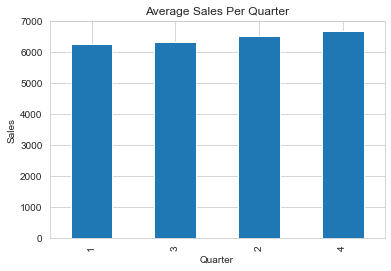

In [12]:
(
    train_df
    .Sales.groupby(train_df['Quarter'])
    .mean()
    .sort_values()
    .plot(
        kind = 'bar',
        title = 'Average Sales Per Quarter',
        ylabel = 'Sales'
    )
);

<AxesSubplot:ylabel='Frequency'>

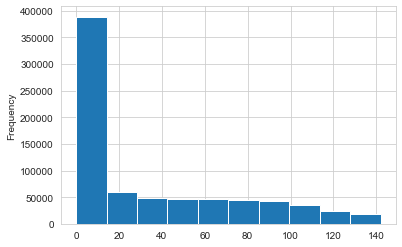

In [13]:
train_df.CompetitionOpen.plot(kind = 'hist')

In [14]:
train_df.Sales.agg(['min', 'max'])

min        0
max    12137
Name: Sales, dtype: int64

In [15]:
train_df.CompetitionOpen.agg(['min', 'max'])

min      0.0
max    142.0
Name: CompetitionOpen, dtype: float64

<AxesSubplot:ylabel='Frequency'>

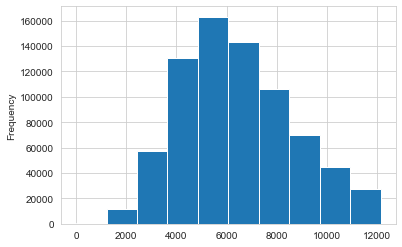

In [16]:
train_df.Sales.plot(kind = 'hist')

### 1.2 `Split`

In [17]:
X = train_df.drop('Sales', axis = 1)
y = train_df.Sales

print('Shape Feature Matrix:', X.shape)
print('Shape Target Vector:', y.shape)

Shape Feature Matrix: (754094, 14)
Shape Target Vector: (754094,)


In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754094 entries, 0 to 1017190
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                754094 non-null  int64  
 1   DayOfWeek            754094 non-null  int64  
 2   Promo                754094 non-null  int64  
 3   StateHoliday         754094 non-null  object 
 4   SchoolHoliday        754094 non-null  int64  
 5   StoreType            754094 non-null  object 
 6   Assortment           754094 non-null  object 
 7   CompetitionDistance  751977 non-null  float64
 8   Promo2               754094 non-null  int64  
 9   Year                 754094 non-null  int64  
 10  Month                754094 non-null  object 
 11  Quarter              754094 non-null  object 
 12  Day                  754094 non-null  int64  
 13  CompetitionOpen      754094 non-null  float64
dtypes: float64(2), int64(7), object(5)
memory usage: 86.3+ MB


In [19]:
cat_cols = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'Promo2', 'Month', 'Quarter']
num_cols = ['Store', 'CompetitionDistance', 'Year', 'Day', 'CompetitionOpen']

In [20]:
cat_cols

['DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'Promo2',
 'Month',
 'Quarter']

### 1.3 `Imputation`

In [21]:
X[num_cols].isna().sum()

Store                     0
CompetitionDistance    2117
Year                      0
Day                       0
CompetitionOpen           0
dtype: int64

In [22]:
test_df[num_cols].isna().sum()

Store                   0
CompetitionDistance    96
Year                    0
Day                     0
CompetitionOpen         0
dtype: int64

In [23]:
max_dis = X['CompetitionDistance'].max()
max_dis

75860.0

In [24]:
X['CompetitionDistance'].fillna((max_dis*2), inplace = True)
test_df['CompetitionDistance'].fillna((max_dis*2), inplace = True)

In [25]:
test_df.isna().sum()

Store                  0
DayOfWeek              0
Promo                  0
StateHoliday           0
SchoolHoliday          0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
Year                   0
Month                  0
Quarter                0
Day                    0
CompetitionOpen        0
dtype: int64

### 1.4 `Scaling`

In [26]:
scaler = MinMaxScaler()
scaler.fit(X[num_cols])

MinMaxScaler()

In [27]:
X[num_cols] = scaler.transform(X[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

In [28]:
test_df[cat_cols].isna().sum()

DayOfWeek        0
Promo            0
StateHoliday     0
SchoolHoliday    0
StoreType        0
Assortment       0
Promo2           0
Month            0
Quarter          0
dtype: int64

### 1.5 `Encode Categorical Feature`

In [29]:
encoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore' )

In [30]:
encoder.fit(X[cat_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [31]:
encoded_cols = list(encoder.get_feature_names_out())
encoded_cols

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'Promo_0',
 'Promo_1',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'SchoolHoliday_0',
 'SchoolHoliday_1',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c',
 'Promo2_0',
 'Promo2_1',
 'Month_Apr',
 'Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jan',
 'Month_Jul',
 'Month_Jun',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sept',
 'Quarter_1',
 'Quarter_2',
 'Quarter_3',
 'Quarter_4']

In [32]:
X[encoded_cols] = encoder.transform(X[cat_cols])
test_df[encoded_cols] = encoder.transform(test_df[cat_cols])

In [33]:
X_train = X[num_cols + encoded_cols]
X_test = test_df[num_cols + encoded_cols]

In [34]:
X_train.sample(10)

,Store,CompetitionDistance,Year,Day,CompetitionOpen,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sept,Quarter_1,Quarter_2,Quarter_3,Quarter_4
744014,0.982047,0.004417,0.0,0.066667,0.528169,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
840846,0.826750,0.013777,0.0,0.233333,0.612676,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
283180,0.053860,0.002175,0.5,0.333333,0.584507,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
952934,0.353680,0.023731,0.0,0.866667,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
203402,0.423698,0.000198,1.0,0.966667,0.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
91273,0.859964,0.006856,1.0,0.333333,0.795775,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
231648,0.756732,0.013250,1.0,0.133333,0.197183,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
149441,0.027828,0.019051,1.0,0.600000,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
522588,0.393178,0.008767,0.5,0.633333,0.380282,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
633967,0.284560,0.212986,0.0,0.300000,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 2. Model Building

In [35]:
?XGBRegressor

In [36]:
model = XGBRegressor(n_estimators = 40, random_state = 42, n_jobs = -1, max_depth = 5)

In [37]:
%%time
model.fit(X_train, y)

CPU times: total: 2min 29s
Wall time: 20.1 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=40, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

### `Prediction` & `Evaluation`

In [38]:
preds = model.predict(X_train)

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
def rmse(a, b):
    return mean_squared_error(a,b, squared = False)

In [41]:
rmse(preds, y)

1524.6079818000971

In [42]:
train_df.Sales.agg(['min', 'max'])

min        0
max    12137
Name: Sales, dtype: int64

### `Visualization`

In [43]:
rcParams['figure.figsize'] = 30, 30

In [44]:
#conda pip install graphviz

<AxesSubplot:>

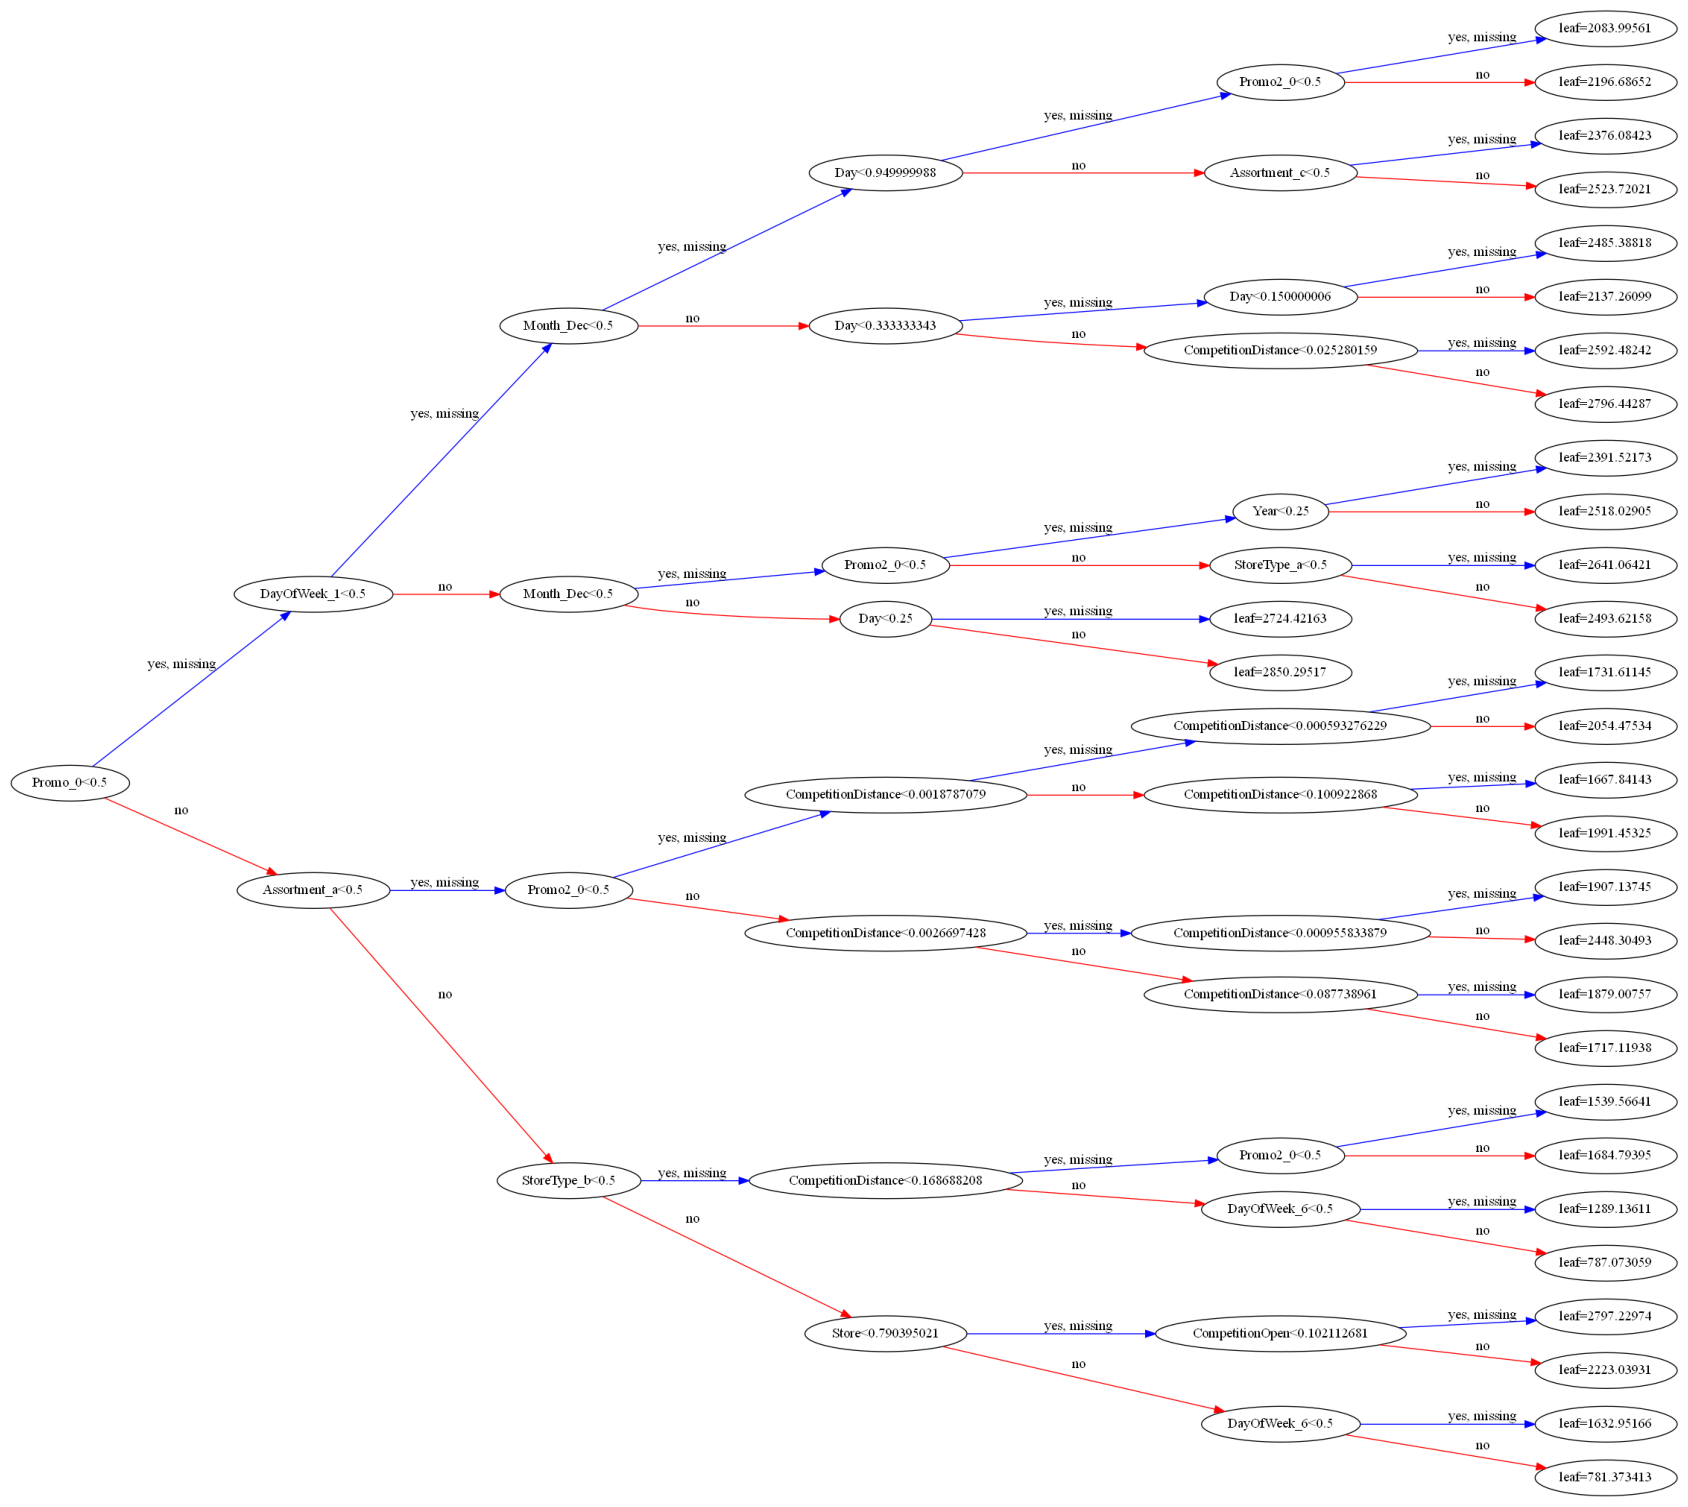

In [45]:
plot_tree(model, rankdir ='LR', num_trees = 0)

<AxesSubplot:>

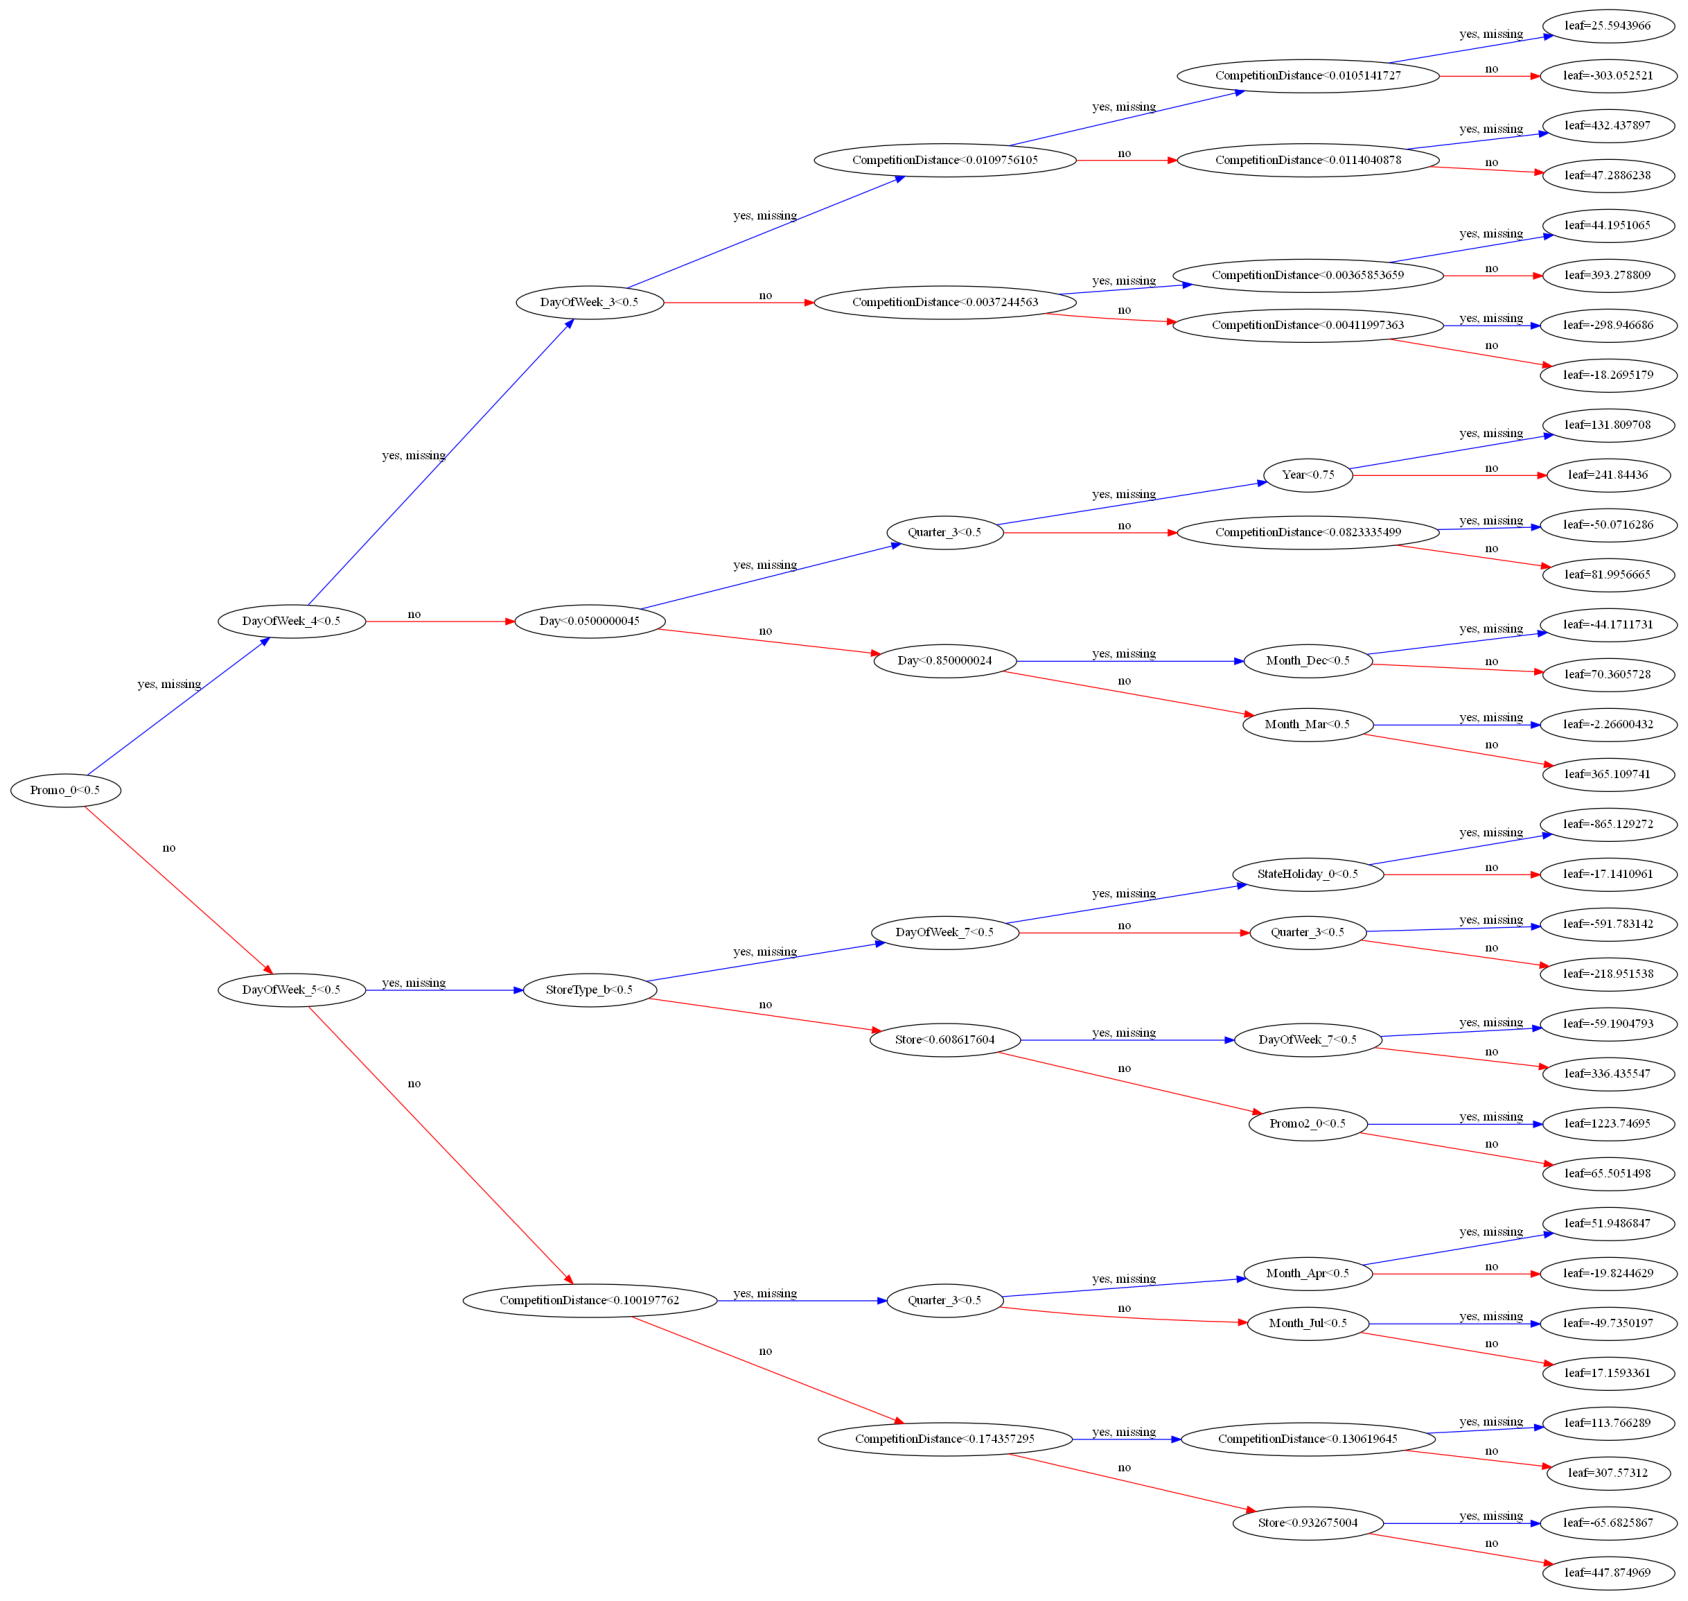

In [46]:
plot_tree(model, rankdir ='LR', num_trees = 19)

<AxesSubplot:>

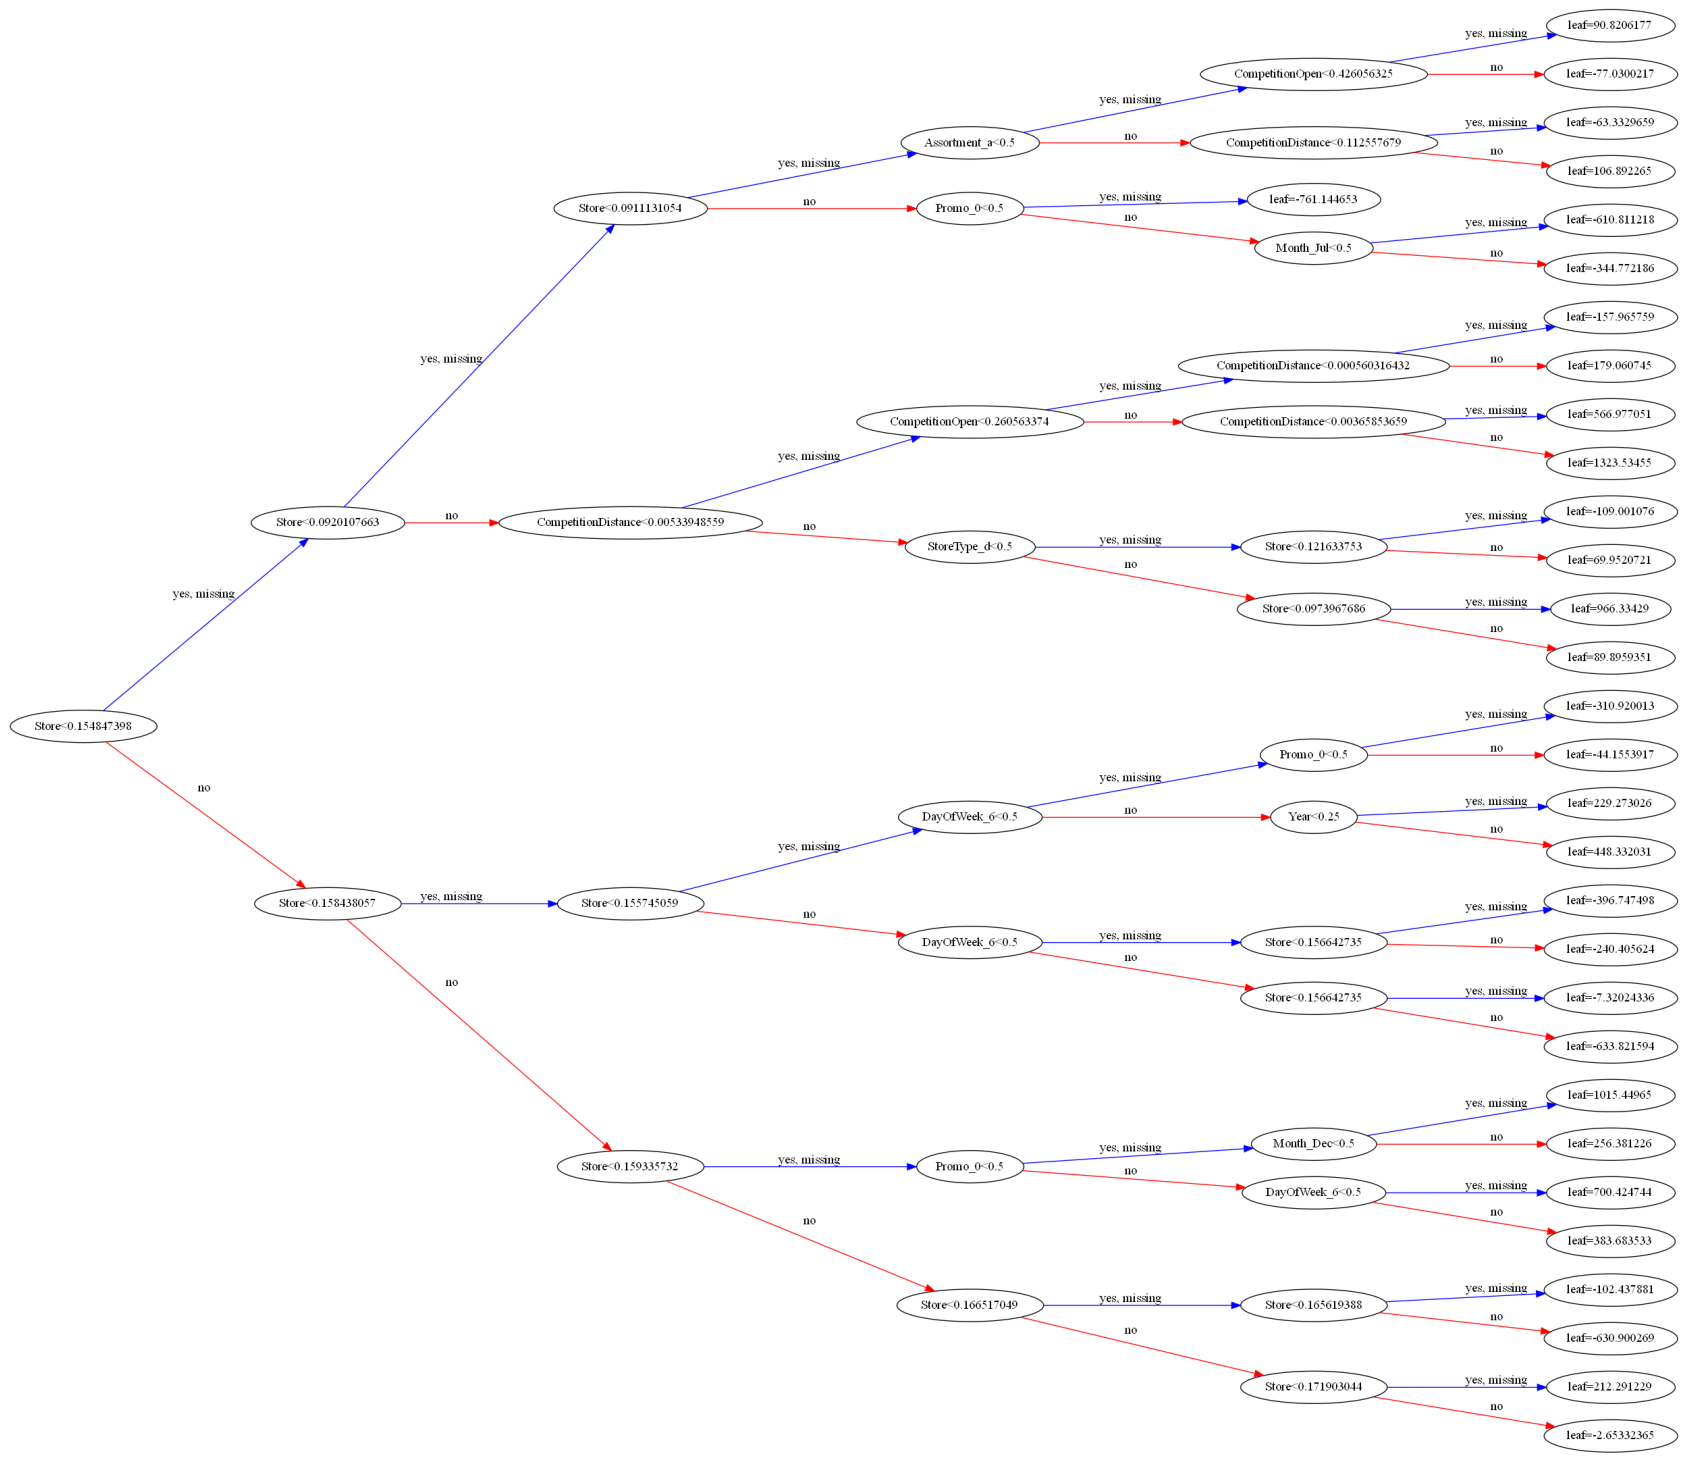

In [47]:
plot_tree(model, rankdir ='LR', num_trees = 39)

In [48]:
tree = model.get_booster().get_dump()
len(tree)

40

In [49]:
print(tree[0])

0:[Promo_0<0.5] yes=1,no=2,missing=1
	1:[DayOfWeek_1<0.5] yes=3,no=4,missing=3
		3:[Month_Dec<0.5] yes=7,no=8,missing=7
			7:[Day<0.949999988] yes=15,no=16,missing=15
				15:[Promo2_0<0.5] yes=31,no=32,missing=31
					31:leaf=2083.99561
					32:leaf=2196.68652
				16:[Assortment_c<0.5] yes=33,no=34,missing=33
					33:leaf=2376.08423
					34:leaf=2523.72021
			8:[Day<0.333333343] yes=17,no=18,missing=17
				17:[Day<0.150000006] yes=35,no=36,missing=35
					35:leaf=2485.38818
					36:leaf=2137.26099
				18:[CompetitionDistance<0.025280159] yes=37,no=38,missing=37
					37:leaf=2592.48242
					38:leaf=2796.44287
		4:[Month_Dec<0.5] yes=9,no=10,missing=9
			9:[Promo2_0<0.5] yes=19,no=20,missing=19
				19:[Year<0.25] yes=39,no=40,missing=39
					39:leaf=2391.52173
					40:leaf=2518.02905
				20:[StoreType_a<0.5] yes=41,no=42,missing=41
					41:leaf=2641.06421
					42:leaf=2493.62158
			10:[Day<0.25] yes=21,no=22,missing=21
				21:leaf=2724.42163
				22:leaf=2850.29517
	2:[Assortment_a<0.5] y

### `Feature Importance`


In [50]:
weights = model.feature_importances_
weights

array([0.0344975 , 0.03590279, 0.00896098, 0.02219361, 0.01796372,
       0.08922862, 0.035083  , 0.00764583, 0.00944451, 0.02254015,
       0.01309903, 0.0226114 , 0.25278667, 0.        , 0.01127864,
       0.00255825, 0.        , 0.        , 0.00436708, 0.        ,
       0.02452552, 0.03543175, 0.03860941, 0.01638985, 0.0470996 ,
       0.00366027, 0.0212153 , 0.04391845, 0.        , 0.00591922,
       0.00842568, 0.03318084, 0.00568427, 0.012845  , 0.00107289,
       0.00355184, 0.00769323, 0.01720643, 0.02343424, 0.01087901,
       0.01246817, 0.00720176, 0.01144101, 0.00654825, 0.01143636],
      dtype=float32)

In [51]:
weight_df = pd.DataFrame({
    'features': X_train.columns,
    'importance': weights
}).sort_values(by = 'importance', ascending = False)
weight_df.head()

,features,importance
12,Promo_0,0.252787
5,DayOfWeek_1,0.089229
24,Assortment_a,0.047100
27,Promo2_0,0.043918
22,StoreType_c,0.038609


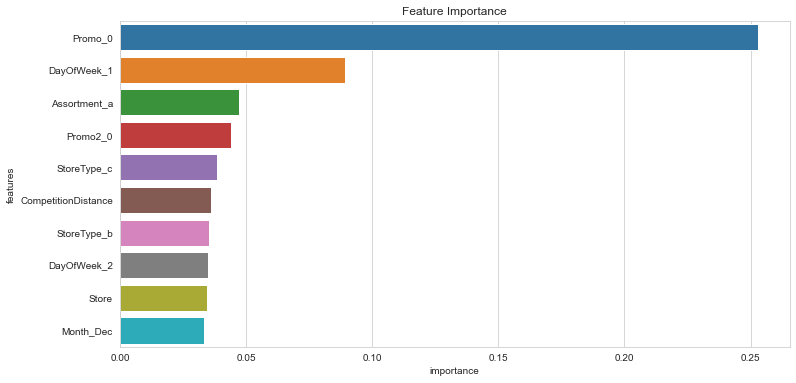

In [52]:
plt.figure(figsize = (12,6))
sns.barplot(x = 'importance', y = 'features', data = weight_df.head(10))
plt.title('Feature Importance');

### `K Fold Cross Validation`

In [53]:
# def train_and_evaluate(X_train, y_train, X_val, y_val, **params):
#     model = XGBRegressor(random_state = 42, n_jobs = -1, **params)
#     model.fit(X_train, y_train)
    
#     train_rmse = mean_squared_error(model.predict(X_train), y_train)
#     val_rmse = mean_squared_error(model.predict(X_val), y_val)
#     score_train = model.score(X_train, y_train)
#     score_val = model.score(X_val, y_val)
   
#     return model, train_rmse, val_rmse, score_train, score_val

In [54]:
# kfold = KFold(n_splits=5)

In [55]:
# %%time
# models = []
# for train_id, val_id in kfold.split(X):
#     X_train, y_train = X.iloc[train_id], y.iloc[train_id]
#     X_val, y_val = X.iloc[val_id], y.iloc[val_id]
    
#     model, train_rmse, val_rmse, score_train, score_val = train_and_evaluate(X_train, y_train, X_val, y_val, max_depth = 5, n_estimators = 40)
#     models.append(model)
    
#     print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")
#     print(f"Train Score: {score_train}, Validation Score: {score_val}")

In [56]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [79]:
params = {
    'n_estimators': range(50,600,100),
     'max_depth': range(2,26, 2)
}

In [80]:
clf = XGBRegressor(random_state = 42 )

In [81]:
model = RandomizedSearchCV(clf, params, cv = 5, n_jobs = -1)

In [ ]:
%%time
model.fit(X_train, y)

In [ ]:
model.cv_results_

In [ ]:
df = pd.DataFrame(model.cv_results_)
df.to_parquet('cv_results.parquet')